In [7]:
# Dependencies
!pip install pyspark seaborn plotly


In [8]:
# Imports
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window


In [9]:
spark = SparkSession.builder.appName("SalesDashboard").getOrCreate()


In [10]:
# Loading sample data
from io import StringIO

csv_data = StringIO("""
order_id,date,region,product,quantity,unit_price
1,2024-01-10,North,Widget A,10,20
2,2024-01-12,South,Widget B,5,30
3,2024-02-05,East,Widget C,15,25
4,2024-02-15,West,Widget A,8,20
5,2024-03-01,North,Widget B,12,30
6,2024-03-10,South,Widget C,10,25
7,2024-03-20,East,Widget A,14,20
8,2024-04-01,West,Widget B,6,30
9,2024-04-08,North,Widget A,5,20
10,2024-04-15,South,Widget B,7,30
""")

pdf = pd.read_csv(csv_data, parse_dates=["date"])
pdf.to_csv("sales_data.csv", index=False)
df = spark.read.csv("sales_data.csv", header=True, inferSchema=True)


In [11]:
# Clean & transform
df = df.withColumn("total_sales", F.col("quantity") * F.col("unit_price"))
df = df.withColumn("month", F.date_format("date", "yyyy-MM"))

# Filter bad data (optional example)
df = df.filter((F.col("quantity") > 0) & (F.col("unit_price") > 0))

df.show()


+--------+----------+------+--------+--------+----------+-----------+-------+
|order_id|      date|region| product|quantity|unit_price|total_sales|  month|
+--------+----------+------+--------+--------+----------+-----------+-------+
|       1|2024-01-10| North|Widget A|      10|        20|        200|2024-01|
|       2|2024-01-12| South|Widget B|       5|        30|        150|2024-01|
|       3|2024-02-05|  East|Widget C|      15|        25|        375|2024-02|
|       4|2024-02-15|  West|Widget A|       8|        20|        160|2024-02|
|       5|2024-03-01| North|Widget B|      12|        30|        360|2024-03|
|       6|2024-03-10| South|Widget C|      10|        25|        250|2024-03|
|       7|2024-03-20|  East|Widget A|      14|        20|        280|2024-03|
|       8|2024-04-01|  West|Widget B|       6|        30|        180|2024-04|
|       9|2024-04-08| North|Widget A|       5|        20|        100|2024-04|
|      10|2024-04-15| South|Widget B|       7|        30|       

In [12]:
# Create CTEs and use window functions
# 1. Monthly sales per region
monthly_sales = df.groupBy("region", "month") \
                  .agg(F.sum("total_sales").alias("monthly_sales"))

# 2. MoM (Month-over-Month) growth
window_spec = Window.partitionBy("region").orderBy("month")
monthly_sales = monthly_sales.withColumn("previous_sales", F.lag("monthly_sales").over(window_spec))
monthly_sales = monthly_sales.withColumn("MoM_growth",
                                          F.round((F.col("monthly_sales") - F.col("previous_sales")) / F.col("previous_sales") * 100, 2))

# 3. Top product per region
product_rank = df.groupBy("region", "product") \
                 .agg(F.sum("total_sales").alias("total_product_sales"))

window_spec_rank = Window.partitionBy("region").orderBy(F.desc("total_product_sales"))
product_rank = product_rank.withColumn("rank", F.rank().over(window_spec_rank))
top_products = product_rank.filter("rank = 1")


In [13]:
# Converting to Pandas for visualization
monthly_sales_pd = monthly_sales.toPandas()
top_products_pd = top_products.toPandas()


In [14]:
# Plotly line chart with MoM growth
fig = px.line(monthly_sales_pd, x="month", y="monthly_sales", color="region", markers=True,
              title="Monthly Sales by Region")
fig.update_traces(mode="lines+markers+text", text=monthly_sales_pd["MoM_growth"].astype(str) + "%", textposition="top center")
fig.show()


In [15]:
# Bar chart – Top Product per Region
fig2 = px.bar(top_products_pd, x="region", y="total_product_sales", color="product",
              title="Top-Selling Product by Region", text="product")
fig2.show()


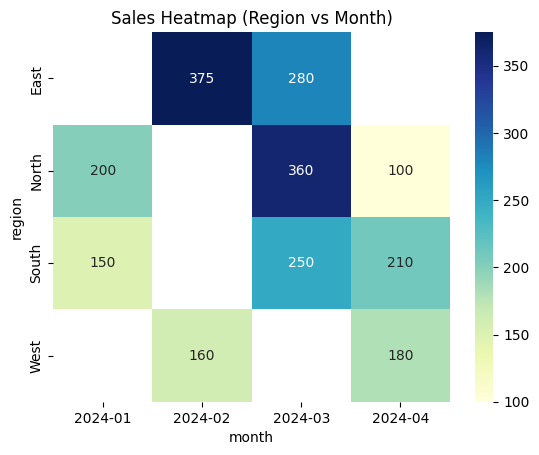

In [16]:
# Heatmap – Region vs Month sales
heatmap_df = monthly_sales_pd.pivot(index="region", columns="month", values="monthly_sales")
sns.heatmap(heatmap_df, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Sales Heatmap (Region vs Month)")
plt.show()
